In [3]:
import numpy as np 
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from statsmodels.graphics.gofplots import qqplot

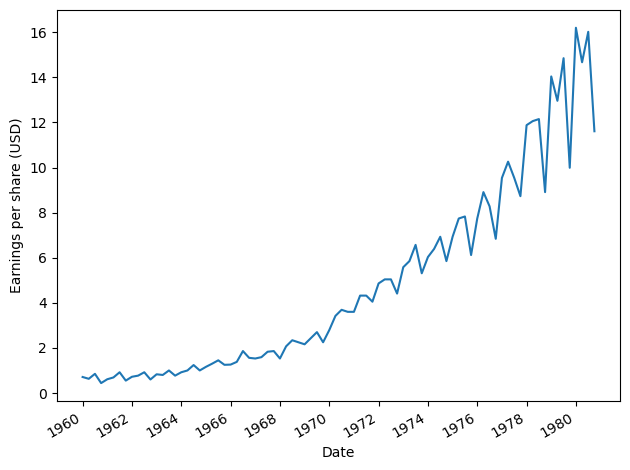

In [4]:
df = pd.read_csv('jj.csv')

fig, ax = plt.subplots() 

ax.plot(df.date, df.data) 
ax.set_xlabel('Date') 
ax.set_ylabel('Earnings per share (USD)')

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980]) 

fig.autofmt_xdate() 
plt.tight_layout()



In [5]:
ad_fuller_result = adfuller(df['data']) 

print(f'ADF Statistic: {ad_fuller_result[0]}') 
print(f'p-value: {ad_fuller_result[1]}') 


ADF Statistic: 2.742016573457468
p-value: 1.0


In [6]:
eps_diff = np.diff(df['data'], n=1) 

ad_fuller_result = adfuller(eps_diff) 

print(f'ADF Statistic: {ad_fuller_result[0]}') 
print(f'p-value: {ad_fuller_result[1]}')



ADF Statistic: -0.40740976363804093
p-value: 0.9088542416911314


In [7]:
eps_diff2 = np.diff(eps_diff, n=1) 

ad_fuller_result = adfuller(eps_diff2) 

print(f'ADF Statistic: {ad_fuller_result[0]}') 
print(f'p-value: {ad_fuller_result[1]}')


ADF Statistic: -3.5851628747931485
p-value: 0.006051099869603805


In [8]:
from typing import Union 
from tqdm import tqdm_notebook 
from statsmodels.tsa.statespace.sarimax import SARIMAX 

def optimize_ARMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame: 
    results = [] 

    for order in tqdm_notebook(order_list): 
        try: 
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False) 
        
        except: 
            continue 

        aic = model.aic 
        results.append([order, aic]) 

    result_df = pd.DataFrame(results) 
    result_df.columns = ['(p,q)', 'AIC']

    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True) 


    return result_df

In [9]:
from itertools import product 

ps = range(0, 4, 1) 
qs = range(0, 4, 1) 
d = 2 

order_list = list(product(ps, qs)) 

In [10]:
train = df.data[:-4] 

result_df = optimize_ARMA(train, order_list, d) 
result_df 

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(3, 3)",115.274981
1,"(3, 1)",115.624980
2,"(3, 2)",115.672007
3,"(3, 0)",154.430820
4,"(0, 3)",194.654716
5,"(0, 2)",209.274604
6,"(2, 3)",220.666954
7,"(1, 3)",228.267779
8,"(1, 2)",228.935821
9,"(2, 2)",229.974649


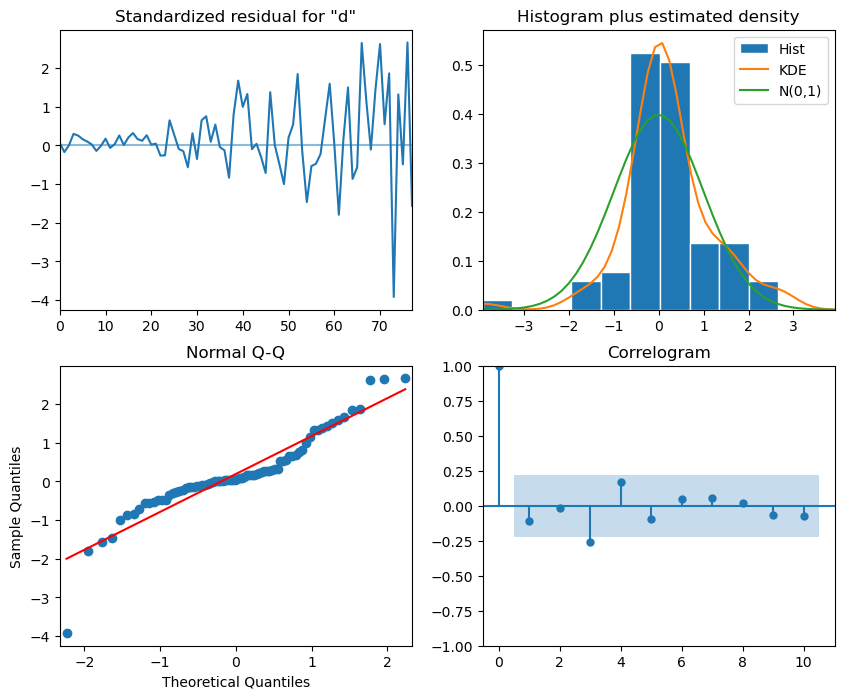

In [11]:
model = SARIMAX(train, order=(3,2,3), simple_differencing=False)
model_fit = model.fit(disp=False)

model_fit.plot_diagnostics(figsize=(10,8));

In [12]:
from statsmodels.stats.diagnostic import acorr_ljungbox 

residuals = model_fit.resid 

lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1)) 

print(pvalue)

lb_pvalue


In [13]:
test = df.iloc[-4:] 

test['naive_seasonal'] = df['data'].iloc[76:80].values 

In [14]:
ARIMA_pred = model_fit.get_prediction(80, 83).predicted_mean 
test['ARIMA_pred'] = ARIMA_pred

In [16]:
df

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61
...,...,...
79,1979-10-01,9.99
80,1980-01-01,16.20
81,1980-04-01,14.67
82,1980-07-02,16.02


In [15]:
test

,date,data,naive_seasonal,ARIMA_pred
80,1980-01-01,16.20,14.04,15.847001
81,1980-04-01,14.67,12.96,14.380854
82,1980-07-02,16.02,14.85,16.369133
83,1980-10-01,11.61,9.99,11.684084


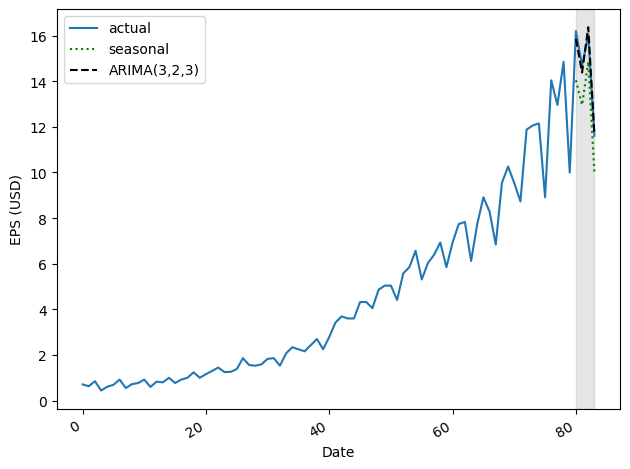

In [23]:
fig, ax = plt.subplots() 

ax.plot(df['data'], label='actual')
ax.plot(test['naive_seasonal'], 'g:', label='seasonal') 
ax.plot(test['ARIMA_pred'], 'k--', label='ARIMA(3,2,3)') 
ax.legend(loc=2) 
ax.set_xlabel('Date') 
ax.set_ylabel('EPS (USD)') 

ax.axvspan(80, 83, color='#808080', alpha=0.2)


fig.autofmt_xdate() 
plt.tight_layout()

In [24]:
def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100 

mape_naive_seasonal = mape(test['data'], test['naive_seasonal']) 


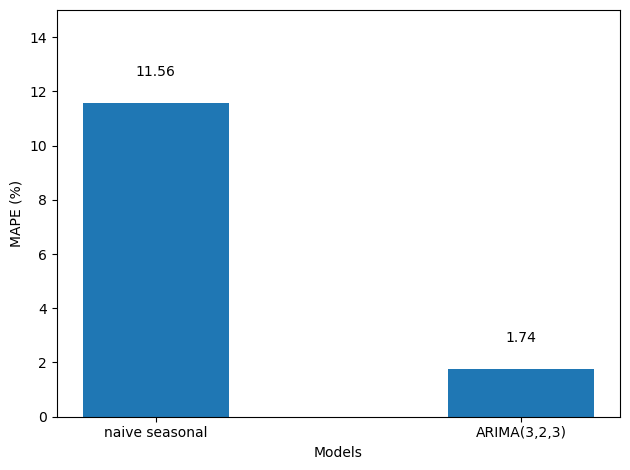

In [25]:
mape_ARIMA = mape(test['data'], test['ARIMA_pred']) 

fig, ax = plt.subplots() 

x = ['naive seasonal', 'ARIMA(3,2,3)']
y = [mape_naive_seasonal, mape_ARIMA] 

ax.bar(x, y, width=0.4) 
ax.set_xlabel('Models') 
ax.set_ylabel('MAPE (%)') 
ax.set_ylim(0, 15) 

for index, value in enumerate(y): 
    plt.text(x=index, y=value+1, s=str(round(value,2)), ha='center') 

plt.tight_layout()